# SEPTA Subway Zoning Analysis and Ridership Model
## Summary



## Data Wrangling
Although primarily based in Philadelphia County, SEPTA subway stops do venture into or next to neighboring Delaware County. As such, it is necessary to gather zoning data from both counties. Fortunately, they both have easily downloadable zoning maps, unfortunately, in Delaware county zoning codes are determined by individual jurisdictions (townships, boroughs etc.). The data is messy and requires looking at each individual jurisdictions' zoning code to determine the general category of zoning. Philadelphia has a unified zoning code, so it is easier to assimilate each code into a category. 

In [19]:
import fiona
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# driver support for kml files is needed to load in Delware County Zoning data
fiona.drvsupport.supported_drivers['libkml'] = 'rw' 
fiona.drvsupport.supported_drivers['LIBKML'] = 'rw'

### Data Sources:  
Ridership Data: [SEPTA's FY 2023 Route Statistics](https://planning.septa.org/wp-content/uploads/2023/09/2023-ROUTE-STATS-WEB-1.pdf)  
Station Data: [SEPTA Open Data Portal](https://data-septa.opendata.arcgis.com/datasets/1e7754ca5f7d47e480a628e282466428_0/explore?location=40.009335%2C-75.214863%2C11.65)  
Philadelphia Zoning: [City of Philadelphia OpenMaps Dashboard](https://openmaps.phila.gov/)  
Delware County Zoning: [Delaware County Open Data hub](https://delaware-county-pennsylvania-dcpd.hub.arcgis.com/datasets/67e0df30839247f9866177d472cc6d4d_0/explore)  

In [17]:
import warnings
# ignore future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load in the data
ridership = pd.read_csv('/Users/owenmcginley/Documents/Summer Projects/Septa_Subway_Ridership.csv')
stations = gpd.read_file('/Users/owenmcginley/Documents/Summer Projects/Metro_Stations')
philly_zoning = gpd.read_file('/Users/owenmcginley/Documents/Summer Projects/Zoning_BaseDistricts')
delco_zoning = gpd.read_file('/Users/owenmcginley/Documents/Summer Projects/Delaware_County_Zoning.kml')


# Data Cleaning
There are a lot of collumns in the philly_zoning that are not needed for this analysis, so they will be removed. The only data necceesary is the geometry, and the zoning code. There are also some spelling issues that should be fixed to ensure compatibility with delco_zoning. 

In [3]:
philly_zoning.head()

,OBJECTID,CODE,CITYCOR,LONG_CODE,ZONINGGROU,PENDING,PENDINGBIL,PENDINGB_1,SUNSET_DAT,SUNSETBILL,SUNSETBI_1,Shape__Are,Shape__Len,geometry
0,1,SPPOA,0.0,SP-PO-A,Special Purpose,No,N/A,N/A,None,N/A,N/A,3371.062500,257.688146,"POLYGON ((-75.21633 39.95295, -75.21673 39.953..."
1,2,CMX2,0.0,CMX-2,Commercial/Commercial Mixed-Use,No,N/A,N/A,None,N/A,N/A,159.539062,63.896038,"POLYGON ((-75.14301 39.99895, -75.14299 39.998..."
2,3,RSA5,0.0,RSA-5,Residential/Residential Mixed-Use,No,N/A,N/A,None,N/A,N/A,1721.378906,182.886474,"POLYGON ((-75.06130 40.01405, -75.06135 40.014..."
3,4,CMX1,0.0,CMX-1,Commercial/Commercial Mixed-Use,No,N/A,N/A,None,N/A,N/A,137.417969,55.579486,"POLYGON ((-75.10094 39.98413, -75.10097 39.984..."
4,5,CMX2,0.0,CMX-2,Commercial/Commercial Mixed-Use,No,N/A,N/A,None,N/A,N/A,524.609375,92.058804,"POLYGON ((-75.12863 40.01916, -75.12854 40.019..."


In [4]:
philly_zoning = philly_zoning[['geometry', 'LONG_CODE', 'Shape__Are', 'Shape__Len']]
philly_zoning = philly_zoning.rename(columns = { 'Shape__Are': 'Area', 'Shape__Len': 'Perimeter'})

Now we need to do the same with delco_zoning. 

In [5]:
delco_zoning.head()

,Name,description,timestamp,begin,end,altitudeMode,tessellate,extrude,visibility,drawOrder,...,QA_Municipality,Group_Category,Source,created_user,created_date,last_edited_user,last_edited_date,Shape__Area,Shape__Length,geometry
0,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,None,...,No,R-3,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,8.372311e+06,44018.962780,"MULTIPOLYGON (((-75.26143 39.92126, -75.26112 ..."
1,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,None,...,No,R-1,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,2.431261e+05,2558.622252,"POLYGON ((-75.26782 39.92613, -75.26776 39.926..."
2,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,None,...,No,I - Institutional District,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,4.936619e+06,28391.193442,"MULTIPOLYGON (((-75.25795 39.92439, -75.25777 ..."
3,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,None,...,No,HC - Highway Commercial District,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,2.713381e+06,22258.777867,"MULTIPOLYGON (((-75.27083 39.92057, -75.27066 ..."
4,None,None,NaT,NaT,NaT,None,-1.0,0.0,-1,None,...,No,R-2,Zoning Districts shown are taken from Darby Bo...,None,None,None,None,4.110935e+06,23186.859478,"MULTIPOLYGON (((-75.25453 39.91690, -75.25445 ..."


In [6]:
delco_zoning = delco_zoning[['geometry', 'LABEL', 'Shape__Area', 'Shape__Length', 'MUNI_NAME']]
delco_zoning = delco_zoning.rename(columns = { 'Shape__Area': 'Area', 'Shape__Length': 'Perimeter'})

### Zoning Categories
For Philadelphia's zoning, I decided to categorize each zoning code into a general and specific category based on the type of construction permitted and its density. I then mapped these categories to the zoning data using a dictionary. 

In [7]:
# Dictionary to map the zoning categories to the zoning codes
philly_zoning_categories = {
    "RSD-1": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSD-2": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSD-3": ("Residential Zoning Districts", "Single-Family Detached"),
    "RSA-1": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-2": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-3": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-4": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-5": ("Residential Zoning Districts", "Single-Family Attached"),
    "RSA-6": ("Residential Zoning Districts", "Single-Family Attached"),
    "RM-1": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-2": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-3": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RM-4": ("Residential Zoning Districts", "Multi-Family Residential"),
    "RMX-1": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RMX-2": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RMX-3": ("Residential Zoning Districts", "Mixed-Use Residential"),
    "RTA-1": ("Residential Zoning Districts", "Two-Family Residential"),
    "RTA-2": ("Residential Zoning Districts", "Two-Family Residential"),
    "CMX-1": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-2": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-2.5": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "CMX-3": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "CMX-4": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "CMX-5": ("Commercial Zoning Districts", "Center City Commercial"),
    "CA-1": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "CA-2": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "I-1": ("Industrial Zoning Districts", "Light and Medium Industrial"),
    "I-2": ("Industrial Zoning Districts", "Light and Medium Industrial"),
    "I-3": ("Industrial Zoning Districts", "Heavy Industrial"),
    "I-P": ("Industrial Zoning Districts", "Port Industrial"),
    "IRMX": ("Industrial Zoning Districts", "Industrial Mixed-Use"),
    "ICMX": ("Industrial Zoning Districts", "Industrial Mixed-Use"),
    "SP-INS": ("Special Purpose Zoning Districts", "Institutional"),
    "SP-CIV": ("Special Purpose Zoning Districts", "Civic, Educational and Medical"),
    "SP-ENT": ("Special Purpose Zoning Districts", "Entertainment"),
    "SP-PO-A": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
    "SP-PO-P": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
    "SP-STA": ("Special Purpose Zoning Districts", "Sports Stadium"),
    "SP-AIR": ("Special Purpose Zoning Districts", "Airport")
}
# Map the zoning categories to the zoning codes
philly_zoning['LONG_CODE'] = philly_zoning['LONG_CODE'].astype(str)
philly_zoning['General_Category'] = philly_zoning['LONG_CODE'].map(philly_zoning_categories).str[0]
philly_zoning['Specific_Category'] = philly_zoning['LONG_CODE'].map(philly_zoning_categories).str[1]
philly_zoning.head()

,geometry,LONG_CODE,Area,Perimeter,General_Category,Specific_Category
0,"POLYGON ((-75.21633 39.95295, -75.21673 39.953...",SP-PO-A,3371.062500,257.688146,Special Purpose Zoning Districts,Parks and Open Spaces
1,"POLYGON ((-75.14301 39.99895, -75.14299 39.998...",CMX-2,159.539062,63.896038,Commercial Zoning Districts,Neighborhood Commercial
2,"POLYGON ((-75.06130 40.01405, -75.06135 40.014...",RSA-5,1721.378906,182.886474,Residential Zoning Districts,Single-Family Attached
3,"POLYGON ((-75.10094 39.98413, -75.10097 39.984...",CMX-1,137.417969,55.579486,Commercial Zoning Districts,Neighborhood Commercial
4,"POLYGON ((-75.12863 40.01916, -75.12854 40.019...",CMX-2,524.609375,92.058804,Commercial Zoning Districts,Neighborhood Commercial


In [8]:
# Remove the Norristown Highspeed Line from the stations data provided by SEPTA
stations = stations[~(stations['Route'] == 'Norristown Highspeed Line')]  

# Convert the coordinate reference system of the data to EPSG:3347 (meter-based projection)
stations = stations.to_crs("EPSG:3347")  
delco_zoning = delco_zoning.to_crs("EPSG:3347")  
philly_zoning = philly_zoning.to_crs("EPSG:3347")  


In [9]:
# Add the name of the line to stations that have duplicate names
stations['Station'] = np.where(stations['Station'].duplicated(), stations['Station'] + ' ' + stations['Route'], stations['Station'])
stations.head()

,FID,Route,Station,Latitude,Longitude,geometry
0,1,Broad Street Line,NRG,39.905434,-75.173936,POINT (7675150.622 591876.943)
1,2,Broad Street Line,Oregon,39.916815,-75.171339,POINT (7675032.079 593212.907)
2,3,Broad Street Line,Snyder,39.924386,-75.169681,POINT (7674947.161 594099.973)
3,4,Broad Street Line,Tasker-Morris,39.929848,-75.168501,POINT (7674884.506 594739.534)
4,5,Broad Street Line,Ellsworth-Federal,39.936194,-75.167129,POINT (7674811.662 595482.599)


### Delaware County Zoning
Assigning categories to zoning parcels in Delaware County will not be as straightforward as it was for Philadelphia. As previously mentioned, each low level jurisdiction determines its zoning code, so its necessary to look into their individual zoning codes. However, we can make this process much easier only categorizing the zoning codes of jurisdictions near subway stations. To do this, I created a buffer of 800 meters (1/2 mile), about a 15 minute walk, around each station. I then overlayed that buffer the zoning data for Delaware County and created a new geodataframe from what intersected. From there I can find any unique values in the 'MUNI_NAME' column, those will be the jurisdictions I need zoning data from.

In [10]:
stations['Station'] = np.where(stations['Station'].duplicated(), stations['Station'] + ' ' + stations['Route'], stations['Station'])

stations_buffered = stations.copy()
stations_buffered['geometry'] = stations.geometry.buffer(800)  # Buffer by 800 meters

zoning_near_delco = gpd.overlay(delco_zoning, stations_buffered, how='intersection')

print(zoning_near_delco['MUNI_NAME'].unique())

['Millbourne Borough' 'Upper Darby Township']


There it is! So now I just need to find zoning information of Milbourne Borough and Upper Darby Township and build a dictionary to map to the data.

In [11]:
# Dictionary for Upper Darby Township
upper_darby_zoning_categories = {
    "R-3": ("Residential Zoning Districts", "Single-Family Detached"),
    "R-4": ("Residential Zoning Districts", "Single-Family Detached"),
    "C-1": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "C-3": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "C-4": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "REC": ("Special Purpose Zoning Districts", "Parks and Open Spaces"),
}
# Dictionary for Milbourne Borough
milbourne_zoning_categories = {
    "R-1": ("Residential Zoning Districts", "Single-Family Detached"),
    "R-2": ("Residential Zoning Districts", "Single-Family Attached"),
    "NBD": ("Commercial Zoning Districts", "Neighborhood Commercial"),
    "GBD": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
    "PCD": ("Commercial Zoning Districts", "Community and Regional Commercial"),
    "C-INS": ("Commercial Zoning Districts", "Auto-Oriented Commercial"),
}

# There are no overlapping zoning codes between the two municipalities so I can combine them into one dictionary
delco_zoning_categories = upper_darby_zoning_categories | milbourne_zoning_categories
delco_zoning_categories
delco_zoning = delco_zoning[(delco_zoning['MUNI_NAME'] == 'Millbourne Borough') | (delco_zoning['MUNI_NAME'] == 'Upper Darby Township')]
delco_zoning['LABEL'] = delco_zoning['LABEL'].astype(str)
delco_zoning['General_Category'] = delco_zoning['LABEL'].map(delco_zoning_categories).str[0]
delco_zoning['Specific_Category'] = delco_zoning['LABEL'].map(delco_zoning_categories).str[1]
delco_zoning.head()

,geometry,LABEL,Area,Perimeter,MUNI_NAME,General_Category,Specific_Category
44,"POLYGON ((7666678.563 596782.397, 7666677.202 ...",PCD,831740.841046,6690.874739,Millbourne Borough,Commercial Zoning Districts,Community and Regional Commercial
157,"POLYGON ((7666288.514 596420.961, 7666298.824 ...",R-2,375919.515932,2871.064755,Millbourne Borough,Residential Zoning Districts,Single-Family Attached
158,"POLYGON ((7666302.130 596390.609, 7666274.391 ...",GBD,242147.625784,2756.399406,Millbourne Borough,Commercial Zoning Districts,Auto-Oriented Commercial
159,"POLYGON ((7666864.083 596634.428, 7666851.899 ...",R-1,287672.464051,2536.802704,Millbourne Borough,Residential Zoning Districts,Single-Family Detached
160,"POLYGON ((7666614.147 596519.517, 7666637.741 ...",NBD,153901.251453,2365.427118,Millbourne Borough,Commercial Zoning Districts,Neighborhood Commercial


Now that we have categorized the relevant zoning data, we can combine it all together in one GeoDataFrame.

In [12]:
# Concatenate the Philadelphia and Delaware County zoning data
zoning = pd.concat([philly_zoning, delco_zoning])

# Select the desired columns from the zoning data
zoning = zoning[['geometry', 'General_Category', 'Specific_Category', 'Area', 'Perimeter']]

# Overlay the zoning data with the buffered stations to find the intersection
zoning_near_stations = gpd.overlay(zoning, stations_buffered, how='intersection')

# Display the head of the zoning data
zoning.head()

,geometry,General_Category,Specific_Category,Area,Perimeter
0,"POLYGON ((7670063.285 596221.905, 7670026.838 ...",Special Purpose Zoning Districts,Parks and Open Spaces,3371.062500,257.688146
1,"POLYGON ((7674999.549 603073.490, 7675001.826 ...",Commercial Zoning Districts,Neighborhood Commercial,159.539062,63.896038
2,"POLYGON ((7681580.877 606664.298, 7681576.861 ...",Residential Zoning Districts,Single-Family Attached,1721.378906,182.886474
3,"POLYGON ((7679072.205 602391.040, 7679068.221 ...",Commercial Zoning Districts,Neighborhood Commercial,137.417969,55.579486
4,"POLYGON ((7675629.210 605671.770, 7675636.690 ...",Commercial Zoning Districts,Neighborhood Commercial,524.609375,92.058804


## Exploratory Data Analysis

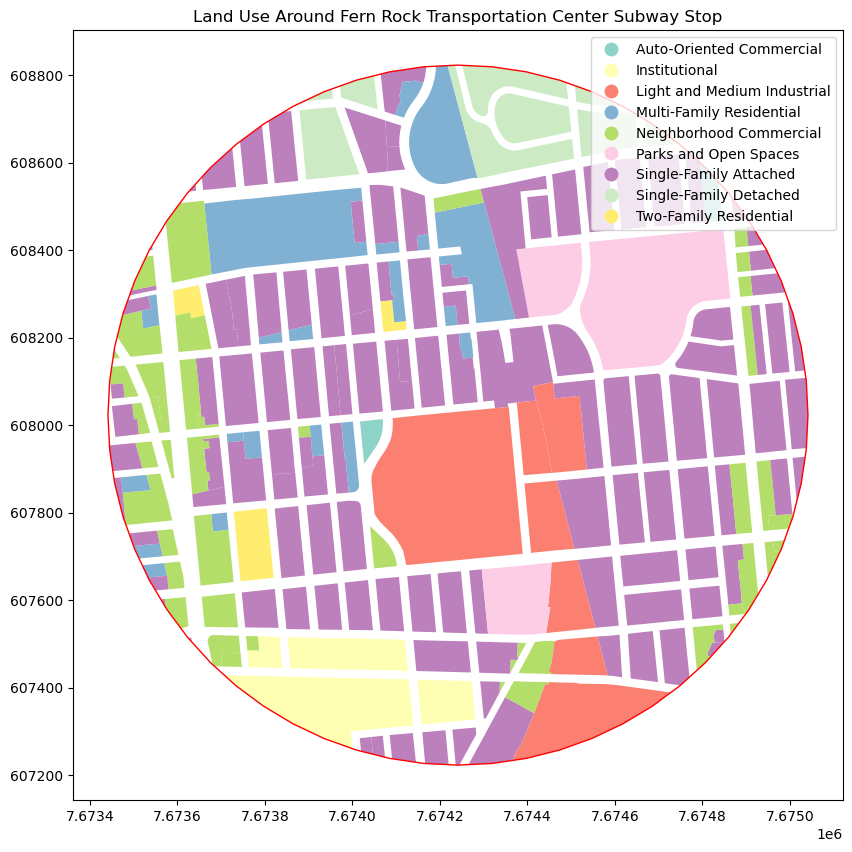

In [13]:
# Plotting an example station buffer with zoning data
station_id = "Fern Rock Transportation Center"
station_area = zoning_near_stations[zoning_near_stations['Station'] == station_id]

fig, ax = plt.subplots(figsize=(10, 10))
station_area.plot(ax=ax, column='Specific_Category', legend=True, cmap='Set3')
stations_buffered[stations_buffered['Station'] == station_id].plot(ax=ax, color='none', edgecolor='red')
plt.title(f'Land Use Around {station_id} Subway Stop')
plt.show()


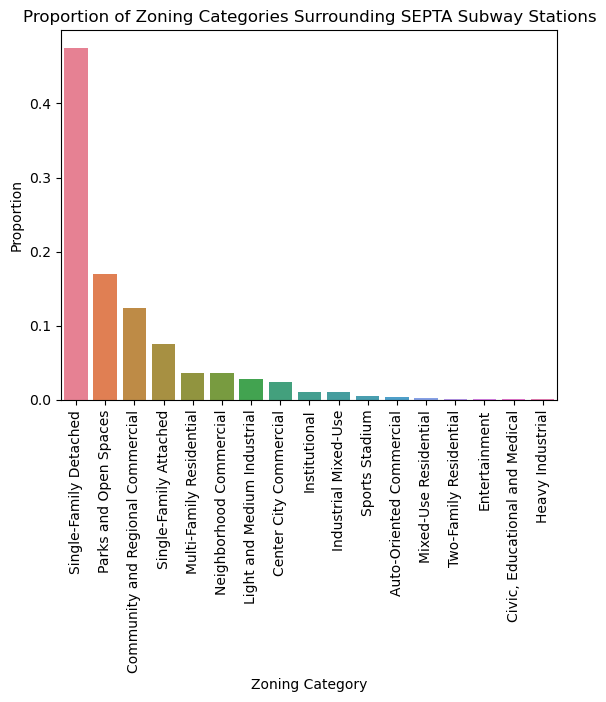

In [14]:
buffer_zones = zoning_near_stations.groupby('Specific_Category')  # Group the data by specific category
all_area = buffer_zones['Area'].sum()  # Calculate the total area for each specific category
proportion = all_area / all_area.sum()  # Calculate the proportion of each category
proportion.sort_values(ascending=False, inplace=True)  # Sort the categories by proportion in descending order

# Plotting the bar chart
sns.barplot(x=proportion.index, y=proportion.values, hue=proportion.index)
plt.ylabel('Proportion')
plt.xlabel('Zoning Category')
plt.xticks(rotation=90)
plt.xticks(proportion.index[:50])  # Set the x-axis ticks at a step of 50
plt.title('Proportion of Zoning Categories Surrounding SEPTA Subway Stations')
plt.show()

## Linear Regression

In [15]:
buffer_L = zoning_near_stations[zoning_near_stations['Route'] == 'Market-Frankford Line']
buffer_B = zoning_near_stations[zoning_near_stations['Route'] == 'Broad Street Line']

# Group the data by specific category for Market-Frankford Line
buffer_L = buffer_L.groupby('Specific_Category')
# Group the data by specific category for Broad Street Line
buffer_B = buffer_B.groupby('Specific_Category')

# Calculate the total area for each specific category for Market-Frankford Line
area_L = buffer_L['Area'].sum()
# Calculate the total area for each specific category for Broad Street Line
area_B = buffer_B['Area'].sum()

# Create a DataFrame to store the area data for both lines
data = pd.DataFrame({'Market-Frankford Line': area_L, 'Broad Street Line': area_B})
data.fillna(0, inplace=True)
data = data.transpose()

# Divide the area values by 10,000 to make the numbers more readable
# The regression model will now be based on how the ridership data changes for every 10,000 square meters of land use
data = data.div(10000)

# Set the index of the data DataFrame to be the line names
ridership.set_index('Line_Name', inplace=True)
# Join the ridership data with the area data based on the line names
data = data.join(ridership, how='inner')


In [38]:
y = data['Daily_Ridership']
X = data.drop(columns='Daily_Ridership')
X = sm.add_constant(X)  # Adds a constant term to the predictor
model = sm.OLS(y, X).fit()
print(model.params)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
const                                 0.008191
Auto-Oriented Commercial              0.260544
Center City Commercial                4.786801
Civic, Educational and Medical        0.035427
Community and Regional Commercial     5.708314
Entertainment                        -0.002919
Heavy Industrial                      0.058094
Industrial Mixed-Use                  1.157177
Institutional                         1.913664
Light and Medium Industrial           4.774631
Mixed-Use Residential                 0.637956
Multi-Family Residential              8.192184
Neighborhood Commercial               3.266878
Parks and Open Spaces                 4.491373
Single-Family Attached               15.174987
Single-Family Detached               -1.68002

## Results Analysis
The results of our regression analysis presents at least one conclusion that I expected, single-family detached zoning is a net negative for transit ridership. 